# Gaussian Mixture Components

### Are Gaussian Mixture Components more Stationary than the main Dataset?

In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

from pathlib import Path
import sys
import time
import os
from copy import copy

script_dir = "../scripts"
sys.path.append(script_dir)

import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from numba import jit
import math

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

plt.style.use('seaborn-talk')
plt.style.use('bmh')
plt.rcParams['font.family'] = 'Bitstream Vera Sans'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7

blue, gold, green, red, purple, brown = sns.color_palette('colorblind', 6)
nanex_colors = ("#f92b20", "#fe701b", "#facd1f", "#d6fd1c", "#65fe1b",
                "#1bfe42", "#1cfdb4", "#1fb9fa", "#1e71fb", "#261cfd")
nanex_cmap = mpl.colors.ListedColormap(nanex_colors,name='nanex_cmap')
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine

Last updated: 2023-08-03T22:55:31.252782+02:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit


pandas           : 1.5.3
pandas_datareader: 0.10.0
numpy            : 1.23.5
sklearn          : 1.2.2
statsmodels      : 0.14.0
scipy            : 1.10.1
matplotlib       : 3.7.1
seaborn          : 0.12.2
plotnine         : 0.12.1



In [2]:
sns_params = {
    "axes.grid": True,
    "ytick.left": True,
    "xtick.bottom": True,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "font.size": 11,
    "font.weight": "medium",
    "figure.figsize": (10, 7),
    "font.family": "DejaVu Sans Mono",  # "Ubuntu Mono",
}

sns.set(context="poster", style="ticks", rc=sns_params)
savefig_kwds = dict(dpi=90, bbox_inches="tight", format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))

### Are the components more stationary than the whole?

Briefly we will examine if the component gaussian's distributions are more stationary than the entire dataset. 
- To test this hypothesis we will use the `adfuller` test from statsmodels. 
- This statistical test gives us insight into whether or not the data set has a unit-root. 
- A unit-root implies a random-walk which is nonstationary. 
- The `adfuller` test assumes there is a unit-root. 
- If the test statistic is smaller than critical values (they are negative) and the p-value is really small there's a strong chance that our data is stationary and thus predictable.

#### Import data

In [3]:
load_rs = '../data/etf_returns_2007-04-11-2023-07-31.csv'

rs = (pd.read_csv(load_rs, index_col=[0])) 
rs.index = pd.DatetimeIndex(rs.index) 
rs = rs.assign(year=lambda df: df.index.year)

rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4105 entries, 2007-04-11 00:00:00+00:00 to 2023-07-31 00:00:00+00:00
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4105 non-null   float64
 1   QQQ     4105 non-null   float64
 2   DIA     4105 non-null   float64
 3   TLT     4105 non-null   float64
 4   GLD     4105 non-null   float64
 5   EFA     4105 non-null   float64
 6   EEM     4105 non-null   float64
 7   BND     4105 non-null   float64
 8   VNQ     4105 non-null   float64
 9   year    4105 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 352.8 KB


In [4]:
sym = "SPY"  # example symbol
df = rs.loc["2008":].copy()
s = df[sym].copy()
s.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3921 entries, 2008-01-02 00:00:00+00:00 to 2023-07-31 00:00:00+00:00
Series name: SPY
Non-Null Count  Dtype  
--------------  -----  
3921 non-null   float64
dtypes: float64(1)
memory usage: 61.3 KB


### ADF test convenience functions

In [5]:
adftest = sm.tsa.adfuller

def get_adf_result(X, test_label):
    res = adftest(X.ravel())
    res_cols = ['test_stat','pval','lag','nobs']
    s = pd.Series(res[:4], index=res_cols)
    s.name = test_label
    
    crit_values = pd.DataFrame.from_dict(res[-2], orient='index')[0]
    s = s.append(crit_values)
    return s

def combine_adf_results(agg_pdfs, x):

    sym_data_res = get_adf_result(x, 'all_data')
    
    results = []
    
    cols = ['all_data']
    for i,c in enumerate(agg_pdfs):
        label = f'component_{i}'
        cols.append(label)
        res = get_adf_result(c, label)
        results.append(res)

    res_df = pd.concat([sym_data_res]+results,axis=1)    
    res_df.columns = cols
    return res_df
    
def make_gmm(n_components, max_iter=150, random_state=RANDOM_STATE):
    """fn: create gmm object"""
    model_kwds = dict(n_components=n_components, 
                      max_iter=max_iter,
                      n_init=100,
                      random_state=RANDOM_STATE)

    gmm = mix.GaussianMixture(**model_kwds)
    return gmm

## Run Experiment

To answer this question we will observe how the adf results change as a function of the lookback periods and the number of components.

In [6]:
def run_model(lookback, n_components, n_split, max_iter=150, plot=True):
    """
    run model and output plots and results, save results to dict
    """
    
    np.random.seed(0)
    
    # stash data in lists
    preds = []
    pred_means = []
    pred_covs = []

    adf_tests = {}

    ### begin plot code ###
    colors = plt.cm.rainbow(np.linspace(0, 1, n_components))

    tscv = TimeSeriesSplit(n_splits=n_split, max_train_size=lookback)
    for i, (train, test) in enumerate(tscv.split(s)):

        tmp_train = s.iloc[train].values.reshape(-1,1) # temporary train data
        tmp_test = s.iloc[test].values.reshape(-1,1) # temporary test data

        gmm = make_gmm(n_components, max_iter=max_iter)
        gmm.fit(tmp_train, s.iloc[train].index.values)

        hidden_states_prob = gmm.predict_proba(tmp_train)
        hidden_states = gmm.predict(tmp_train)

        state_df = (s.iloc[train].to_frame()
                    .assign(component=pd.Categorical(hidden_states))
                    .assign(mkt_cret=lambda df: df[sym].cumsum())
                    .reset_index())

        # reshape observed returns
        x = state_df[sym].sort_values().values.reshape(-1,1)

        # agg pdfs into list
        agg_pdfs = [w * stats.norm.pdf(x, mu, sd) 
                    for mu, sd, w in zip(gmm.means_, np.sqrt(gmm.covariances_), gmm.weights_)]

        adf_test = combine_adf_results(agg_pdfs, x)
        adf_tests[i] = adf_test
        
        if plot:
            print('-'*55)
            print(f'split: {i}')
            display(adf_test)


            fig, ax = plt.subplots(figsize=(10,7))
            # plot observed data distribution #and a single component gaussian fit aka norm fit
            sns.distplot(x, ax=ax, hist=True, hist_kws=dict(alpha=0.25),
                         kde=True, kde_kws=dict(lw=4, label='spy-kde'),
                         label=sym)

            # plot component gaussians  
            for i in range(len(agg_pdfs)): ax.plot(x, agg_pdfs[i], ls='--', label=f'Gaussian {i}');  

            # ax.plot(x, summed_density, color='k')  
            plt.title(f'{sym} kde with component densities')
            plt.legend()    
        
    return adf_tests


#### Demo the model function and plots

-------------------------------------------------------
split: 0


,all_data,component_0,component_1,component_2
test_stat,3.1440,1.7782,-2.5584,-2.4761
pval,1.0000,0.9983,0.1019,0.1214
lag,12.0000,10.0000,10.0000,11.0000
nobs,239.0000,241.0000,241.0000,240.0000
1%,-3.4580,-3.4578,-3.4578,-3.4579
5%,-2.8737,-2.8736,-2.8736,-2.8737
10%,-2.5733,-2.5732,-2.5732,-2.5732


-------------------------------------------------------
split: 1


,all_data,component_0,component_1,component_2
test_stat,3.4875,-3.1938,-5.1301,-3.0934
pval,1.0000,0.0203,0.0000,0.0270
lag,14.0000,13.0000,7.0000,13.0000
nobs,237.0000,238.0000,244.0000,238.0000
1%,-3.4582,-3.4581,-3.4574,-3.4581
5%,-2.8738,-2.8738,-2.8735,-2.8738
10%,-2.5733,-2.5733,-2.5731,-2.5733


-------------------------------------------------------
split: 2


,all_data,component_0,component_1,component_2
test_stat,1.7031,-1.1248,2.5116,-3.0830
pval,0.9981,0.7051,0.9991,0.0278
lag,16.0000,11.0000,6.0000,15.0000
nobs,235.0000,240.0000,245.0000,236.0000
1%,-3.4585,-3.4579,-3.4573,-3.4584
5%,-2.8739,-2.8737,-2.8734,-2.8739
10%,-2.5734,-2.5732,-2.5731,-2.5733


-------------------------------------------------------
split: 3


,all_data,component_0,component_1,component_2
test_stat,-0.6940,-3.1807,-2.5980,-2.3192
pval,0.8483,0.0211,0.0934,0.1658
lag,16.0000,14.0000,7.0000,10.0000
nobs,235.0000,237.0000,244.0000,241.0000
1%,-3.4585,-3.4582,-3.4574,-3.4578
5%,-2.8739,-2.8738,-2.8735,-2.8736
10%,-2.5734,-2.5733,-2.5731,-2.5732


-------------------------------------------------------
split: 4


,all_data,component_0,component_1,component_2
test_stat,4.9657,-2.1162,2.4322,4.6309
pval,1.0000,0.2380,0.9990,1.0000
lag,16.0000,9.0000,14.0000,15.0000
nobs,235.0000,242.0000,237.0000,236.0000
1%,-3.4585,-3.4577,-3.4582,-3.4584
5%,-2.8739,-2.8736,-2.8738,-2.8739
10%,-2.5734,-2.5732,-2.5733,-2.5733


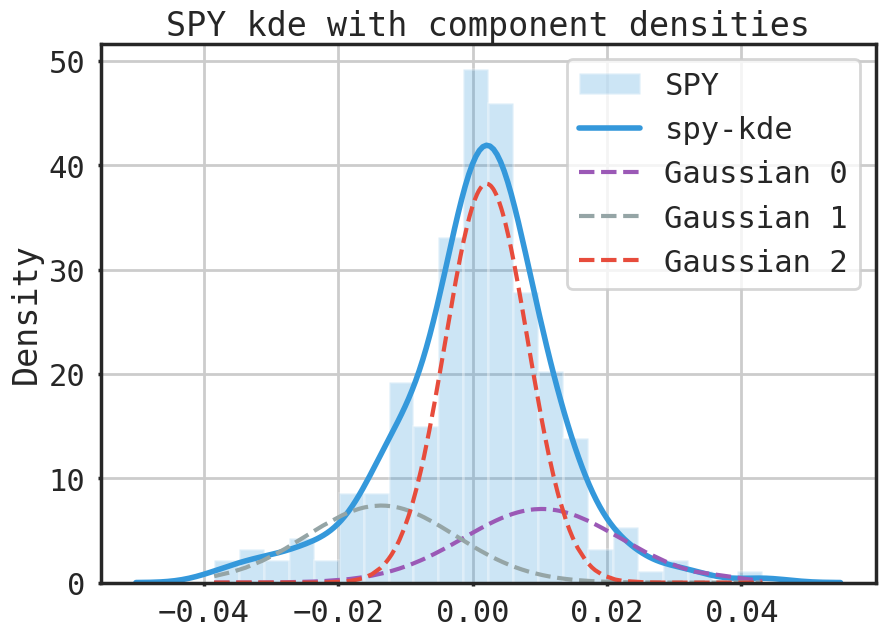

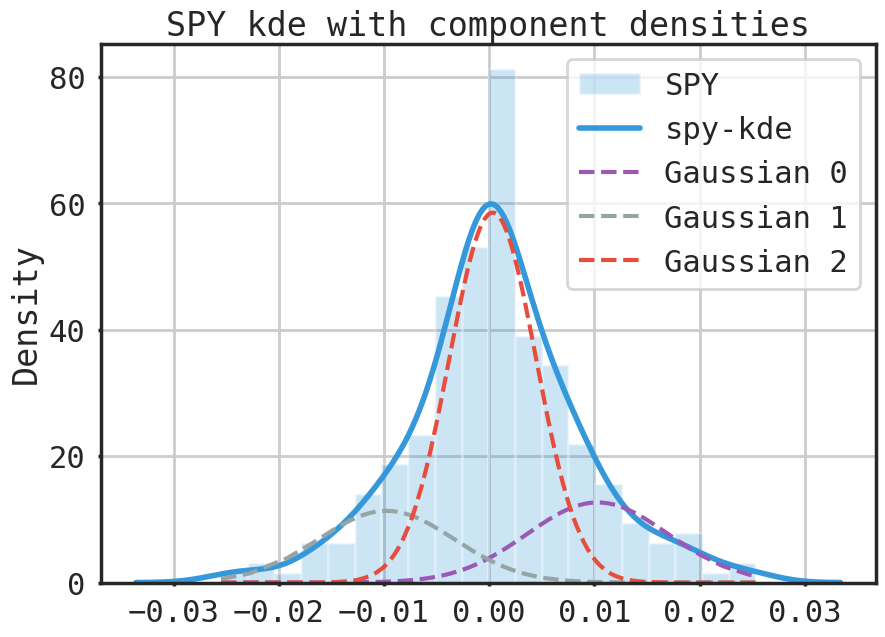

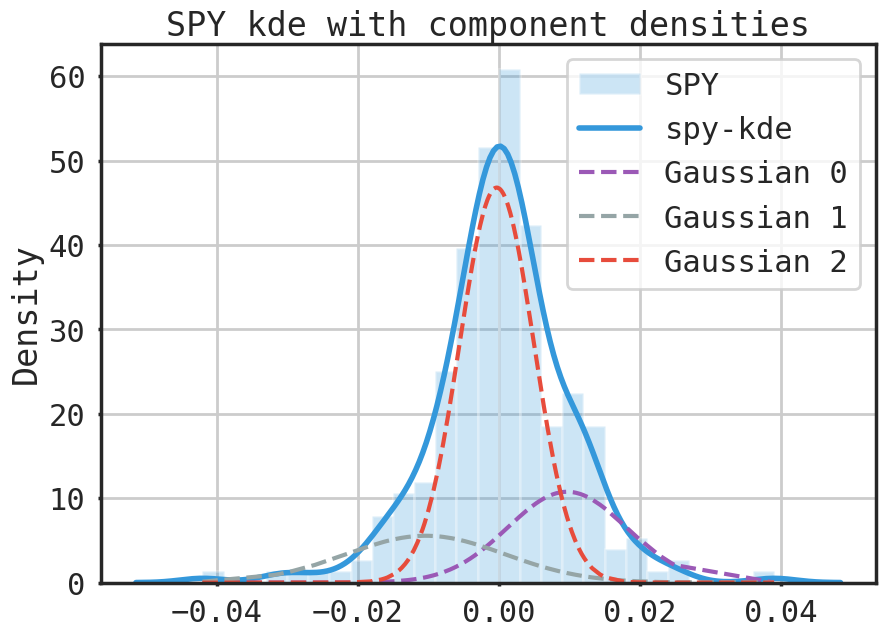

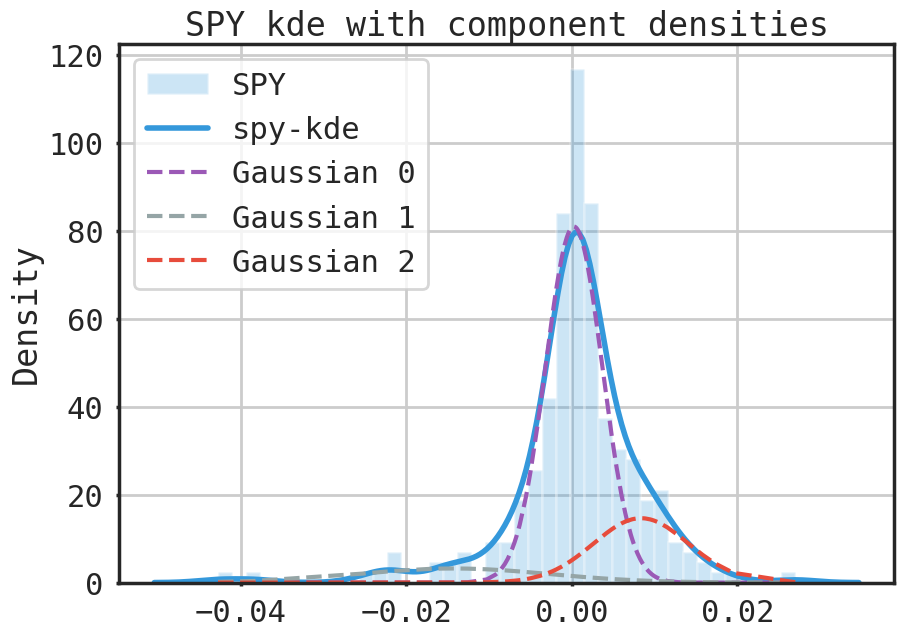

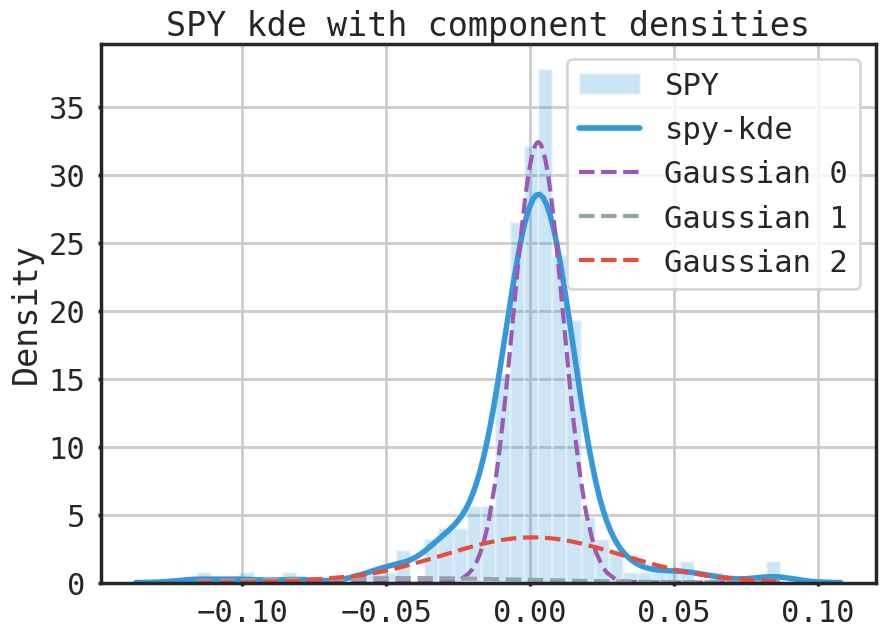

In [7]:
lookback = 252
n_components = 3
n_split = 5

demo_results = run_model(lookback, n_components, n_split)

### Varying the lookback periods

In [8]:
lookback_results = {}

lookbacks = [30,60,90,252,504]
n_components = 3
n_split = 5

for look in lookbacks:
    look_result = run_model(look, n_components, n_split, plot=False)
    lookback_results[look] = look_result

### Varying the number of components

In [9]:
n_mix_results = {}

n_components = [2,3,4,5,7,10]
lookback = 252
n_split = 5

for n in n_components:
    n_result = run_model(lookback, n, n_split, plot=False)
    n_mix_results[n] = n_result

## Evaluate Results

To do this we will look at a description of the pvalues for each parameter combo in comparison to the training data's adf result.

In [10]:
def compute_results(result_dict):
    mean_pval_all_data = {}
    mean_pval_components = {}

    for k in result_dict.keys():
        split_dict = result_dict[k]
        pval_all_data = [split['all_data'].loc['pval'] 
                         for split in split_dict.values()]
        mean_pval_all_data[k] = np.mean(pval_all_data)

        pval_components = [split.drop('all_data',axis=1).loc['pval'].mean()
                           for split in split_dict.values()]
        mean_pval_components[k] = np.mean(pval_components)
    
    df1 = (pd.DataFrame.from_dict(mean_pval_all_data, orient='index')
           .rename(columns={0:'all_data'}))
    df2 = (pd.DataFrame.from_dict(mean_pval_components, orient='index')
           .rename(columns={0:'components'}))
    
    return (pd.concat([df1,df2],axis=1)
            .assign(diff=lambda df: df.all_data - df.components))

### lookback results

In [11]:
ldf = compute_results(lookback_results)
ldf.loc['total_mean'] = ldf.mean(axis=0)
ldf

,all_data,components,diff
30,0.6935,0.2661,0.4274
60,0.9133,0.3429,0.5703
90,0.7799,0.3517,0.4282
252,0.9693,0.3679,0.6014
504,0.9882,0.6749,0.3133
total_mean,0.8688,0.4007,0.4681


We can see that as more data is included in the lookback or training period, the less stationary the training dataset is.

Across all the lookbacks on average the components tend to be *more* stationary than the main dataset.

### number of component results

In [12]:
ndf = compute_results(n_mix_results)
ndf.loc['total_mean'] = ndf.mean(axis=0)
ndf

,all_data,components,diff
2,0.9693,0.6412,0.3281
3,0.9693,0.3679,0.6014
4,0.9693,0.2118,0.7575
5,0.9693,0.2037,0.7656
7,0.9693,0.2692,0.7001
10,0.9693,0.2776,0.6917
total_mean,0.9693,0.3285,0.6407


We can see that holding the lookback constant at 252 the *nonstationarity* of the training dataset remains very high while on average, it appears like more components *increases the stationarity* or *lowers the pvalue*. Let's try it with a `60` day lookback for comparison.

In [13]:
n_mix_results2 = {}

n_components = [2,3,4,5,7,10]
lookback = 60
n_split = 5

for n in n_components:
    n_result = run_model(lookback, n, n_split, plot=False)
    n_mix_results2[n] = n_result
    
ndf2 = compute_results(n_mix_results2)
ndf2.loc['total_mean'] = ndf2.mean(axis=0)
ndf2    

,all_data,components,diff
2,0.9133,0.7200,0.1933
3,0.9133,0.3429,0.5703
4,0.9133,0.2454,0.6679
5,0.9133,0.2358,0.6774
7,0.9133,0.2848,0.6284
10,0.9133,0.2582,0.6551
total_mean,0.9133,0.3479,0.5654


The results are mostly similar to what we observed with the longer lookback except the impact of the number components is less.

## Conclusions

Note that this is a crude way to answer the question. We can see that the component pvals can vary a good amount.

In [14]:
n_mix_results[10][0].drop('all_data',axis=1).loc['pval'].describe()

count   10.0000
mean     0.2352
std      0.4059
min      0.0000
25%      0.0023
50%      0.0247
75%      0.1582
max      1.0000
Name: pval, dtype: float64

In [15]:
lookback_results[60][2].drop('all_data',axis=1).loc['pval'].describe()

count   3.0000
mean    0.6665
std     0.5728
min     0.0051
25%     0.4997
50%     0.9943
75%     0.9971
max     1.0000
Name: pval, dtype: float64

I think we can say that the components are indeed more stationary than the dataset they are drawn from as computed by the `adfuller` test.